# Customer Data Segmentation

General Goals: 
1. Clustering using demographic information 
2. Custering using banking behavious

## Imports

In [1]:
import pandas as pd
import numpy as np

#for moving around os
from os import listdir
from os.path import isfile, join
import glob

#plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly
import plotly.graph_objects as go
import plotly.express as px 
from plotly.subplots import make_subplots #making subplots

# sklearn stuff
import sklearn.preprocessing as preprocessing #using for one-hot-encoding
from sklearn.preprocessing import OneHotEncoder # newer for one-hot encoding
from sklearn.preprocessing import StandardScaler #to normalise data
from sklearn.decomposition import PCA # for PCA 
from sklearn.cluster import KMeans #Kmeans Stuff

#for sql db stuff
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine

#for datetime stuff
import datetime

#widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

#for min-max for radar
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None) # show all columns in DataFrame

## Functions

In [43]:
def check_nulls(df):
    """
    checks to see which rows have null values
    """
    return df.info(), "\n", df.isnull().sum()


def create_connection(path):
    """
    Connect to our SQLite DB
    """
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occured")

    return connection


def execute_query(connection, query):
    """
    Execute a SQLite querry against a db
    """
    cursor = connection.cursor()

    try:
        cursor.execute(query)
        connection.commit()
        print("Query exected successfully")
    except Error as e:
        print(f"The error '{e}' occured")


def execute_read_query(connection, query):
    """
    Execute a querry with fetchall()
    """
    cursor = connection.cursor()
    results = None

    try:
        cursor.execute(query)
        results = cursor.fetchall()
        return results
    except Error as e:
        print(f"The error '{e}' occured")

def one_hot_magic(df_col):
    """ this makes one-hot columns
    """
    targets = df_col
    labelEnc = preprocessing.LabelEncoder()
    new_target = labelEnc.fit_transform(targets)
    onehotEnc = preprocessing.OneHotEncoder()
    onehotEnc.fit(new_target.reshape(-1,1))
    targets_trans = onehotEnc.transform(new_target.reshape(-1,1))
    #print("The original data")
    #print(targets)
    #print("The transform data using OneHotEncoder")
    return targets_trans.toarray()

## Data Setup
The flat csv files for tables is included in the repo. Lets go through setting up a quick SQLite DB locally to querry from. In a live environment you may be connecting directly to a hosted database and can skip this.

### CSV Files

In [3]:
# lets take a look at all files in our data folder
for file in os.listdir("../../data/"):
    print(file) 

twm_credit_tran.csv
twm_savings_tran.csv
twm_checking_tran.csv
twm_customer.csv
twm_checking_acct.csv
twm_savings_acct.csv
twm_accounts.csv
twm_credit_acct.csv
banking_trans.sqlite
twm_transactions.csv


In [6]:
# what about just csv files?

#os.chdir("../../data/") if you want to change the total directory
d_path = "../../data/"
for file in glob.glob(d_path+"*.csv"):
    print(os.path.basename(file)) #prints only filename

twm_credit_tran.csv
twm_savings_tran.csv
twm_checking_tran.csv
twm_customer.csv
twm_checking_acct.csv
twm_savings_acct.csv
twm_accounts.csv
twm_credit_acct.csv
twm_transactions.csv


In [7]:
# import csv files as DataFrames
df_accts = pd.read_csv(d_path+'twm_accounts.csv', delimiter=";")
df_checkings = pd.read_csv(d_path+'twm_checking_acct.csv', delimiter=";")
df_checkings_trans = pd.read_csv(d_path+'twm_checking_tran.csv', delimiter=";")
df_credit = pd.read_csv(d_path+'twm_credit_acct.csv', delimiter=";")
df_credit_trans = pd.read_csv(d_path+'twm_credit_tran.csv', delimiter=";")
df_customer = pd.read_csv(d_path+'twm_customer.csv', delimiter=";")
df_savings = pd.read_csv(d_path+'twm_savings_acct.csv', delimiter=";")
df_savings_trans = pd.read_csv(d_path+'twm_savings_tran.csv', delimiter=";")
df_transactions = pd.read_csv(d_path+'twm_transactions.csv', delimiter=";")

### SQLite Setup

In [8]:
# lets setup a sqlite db and create tables for each
connection = create_connection(d_path + "banking_trans_db.sqlite")

Connection to SQLite DB successful


In [15]:
#looping through table names and object to make a quick sql lite db
table_names = ['df_accts', 'df_checkings', 'df_checkings_trans', 'df_credit', 'df_credit_trans', 'df_customer', 'df_savings', 'df_savings_trans', 'df_transactions']
table_objects = [df_accts, df_checkings, df_checkings_trans, df_credit, df_credit_trans, df_customer, df_savings, df_savings_trans, df_transactions]

for i in range(len(table_names)):
    table_objects[i].to_sql(table_names[i], connection)
    
# Test that data is uploaded to our SQLite DB
pd.DataFrame(execute_read_query(connection, "SELECT * FROM df_customer LIMIT 5;"))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [18]:
# add year / month columns to transaction columns
df_transactions_cleaned = df_transactions.copy()

df_transactions_cleaned['tran_year'] = pd.DatetimeIndex(df_transactions['tran_date']).year
df_transactions_cleaned['tran_month'] = pd.DatetimeIndex(df_transactions['tran_date']).month
df_transactions_cleaned['tran_day'] = pd.DatetimeIndex(df_transactions['tran_date']).dayofweek

#write this df to sql
df_transactions_cleaned.to_sql('df_trans_clean', connection)


## Goal 1: Demographic Clustering
1. Cleaning 
    - Nulls
    - Categorical columns (gender, marial status, state_code, maybe??city_name)
    - Feature Engineering (one-hot etc)
    - Feature Selection: remove (cust_id, first_name, last_name, street_nbr, postal_code)
2. Data Normalization
3. PCA
    - How many dimensions? 
    - Elbow plot
    - Save output dataframe w PC1.2.3.4.etc
4. Cluster w K-means & graph

### 1. Data Cleaning
For this example we are going to use the dataframes already loaded into memory.

In [33]:
# Check and clean NULL values
df_customer.isnull().sum()

cust_id            0
income             0
age                0
years_with_bank    0
nbr_children       0
gender             0
marital_status     0
name_prefix        0
first_name         0
last_name          0
street_nbr         0
street_name        0
postal_code        0
city_name          0
state_code         0
dtype: int64

In [34]:
#strip columns
df_customer_clean = df_customer.copy()
df_customer_clean.drop(axis=1, columns=['cust_id', 'name_prefix', 'first_name', 'last_name', 'street_nbr', 'street_name', 'postal_code', 'city_name'], inplace=True)

,income,age,years_with_bank,nbr_children,gender,marital_status,state_code
0,26150,46,5,1,M,2,NV
1,6605,71,1,0,M,2,CA
2,18548,38,8,0,F,1,CA
3,47668,54,3,0,F,1,CA
4,44554,59,9,2,F,4,NY
...,...,...,...,...,...,...,...
742,14795,36,6,1,F,4,CA
743,26387,56,6,1,M,2,NY
744,61300,50,0,2,M,2,NM
745,15100,37,7,0,F,2,AL


In [35]:
#one-hot encoding gender # this was my origional approach using the sklearn preprocessing method
targets = df_customer_clean['gender']
labelEnc = preprocessing.LabelEncoder()
new_target = labelEnc.fit_transform(targets)
onehotEnc = preprocessing.OneHotEncoder()
onehotEnc.fit(new_target.reshape(-1,1))
targets_trans = onehotEnc.transform(new_target.reshape(-1,1))
# writing the one-hot encodes for gender to new columns
df_customer_clean['gender_F'] = targets_trans.toarray()[:, 0]
df_customer_clean['gender_M'] = targets_trans.toarray()[:, 1]
df_customer_clean.drop(columns='gender', inplace=True)  #removing gender column
df_customer_clean.head()


,income,age,years_with_bank,nbr_children,marital_status,state_code,gender_F,gender_M
0,26150,46,5,1,2,NV,0.0,1.0
1,6605,71,1,0,2,CA,0.0,1.0
2,18548,38,8,0,1,CA,1.0,0.0
3,47668,54,3,0,1,CA,1.0,0.0
4,44554,59,9,2,4,NY,1.0,0.0


In [42]:
# simpler way of doing this is using the pandas encoder method
pd.get_dummies(df_customer['gender'])
# then merge it onto the table

,F,M
0,0,1
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
742,1,0
743,0,1
744,0,1
745,1,0


In [ ]:
# print len of unique states in data = 33
print(df_customer_clean['state_code'].unique().__len__())

#make new one-hot encoding columns for states... 33 cols
new_cols = one_hot_magic(df_customer_clean['state_code'])
print(new_cols.shape)
df_customer_clean['state_code'].value_counts()

In [47]:
#create dumy state columns
new_state_cols = pd.get_dummies(df_customer_clean['state_code'])
df_customer_clean = pd.concat([df_customer_clean, new_state_cols], axis=1)
df_customer_clean.drop(columns='state_code', inplace=True)
df_customer_clean.head()

,income,age,years_with_bank,nbr_children,marital_status,gender_F,gender_M,AL,AZ,CA,CO,DC,FL,GA,HI,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NB,NC,NJ,NM,NV,NY,OH,OK,OR,PA,TN,TX,VA,WA,WI
0,26150,46,5,1,2,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,6605,71,1,0,2,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,18548,38,8,0,1,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,47668,54,3,0,1,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,44554,59,9,2,4,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### 2. Normalize

In [48]:
df_customer_norm = StandardScaler().fit_transform(df_customer_clean)
pd.DataFrame(df_customer_norm, columns=df_customer_clean.columns).head()

,income,age,years_with_bank,nbr_children,marital_status,gender_F,gender_M,AL,AZ,CA,CO,DC,FL,GA,HI,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NB,NC,NJ,NM,NV,NY,OH,OK,OR,PA,TN,TX,VA,WA,WI
0,0.154185,0.184312,0.408539,0.258591,0.132149,-1.127172,1.127172,-0.073373,-0.182195,-0.557249,-0.122252,-0.089984,-0.147945,-0.051813,-0.133083,-0.284679,-0.147945,-0.0635,-0.133083,-0.0635,-0.104045,-0.104045,-0.110432,-0.133083,-0.152603,-0.0635,-0.110432,-0.127775,-0.09726,13.629013,-0.408886,-0.178236,-0.147945,-0.147945,-0.170075,-0.157135,-0.353553,-0.082089,-0.110432,-0.14315
1,-0.726524,1.493070,-1.087435,-0.648298,0.132149,-1.127172,1.127172,-0.073373,-0.182195,1.794530,-0.122252,-0.089984,-0.147945,-0.051813,-0.133083,-0.284679,-0.147945,-0.0635,-0.133083,-0.0635,-0.104045,-0.104045,-0.110432,-0.133083,-0.152603,-0.0635,-0.110432,-0.127775,-0.09726,-0.073373,-0.408886,-0.178236,-0.147945,-0.147945,-0.170075,-0.157135,-0.353553,-0.082089,-0.110432,-0.14315
2,-0.188366,-0.234490,1.530520,-0.648298,-0.989614,0.887176,-0.887176,-0.073373,-0.182195,1.794530,-0.122252,-0.089984,-0.147945,-0.051813,-0.133083,-0.284679,-0.147945,-0.0635,-0.133083,-0.0635,-0.104045,-0.104045,-0.110432,-0.133083,-0.152603,-0.0635,-0.110432,-0.127775,-0.09726,-0.073373,-0.408886,-0.178236,-0.147945,-0.147945,-0.170075,-0.157135,-0.353553,-0.082089,-0.110432,-0.14315
3,1.123798,0.603115,-0.339448,-0.648298,-0.989614,0.887176,-0.887176,-0.073373,-0.182195,1.794530,-0.122252,-0.089984,-0.147945,-0.051813,-0.133083,-0.284679,-0.147945,-0.0635,-0.133083,-0.0635,-0.104045,-0.104045,-0.110432,-0.133083,-0.152603,-0.0635,-0.110432,-0.127775,-0.09726,-0.073373,-0.408886,-0.178236,-0.147945,-0.147945,-0.170075,-0.157135,-0.353553,-0.082089,-0.110432,-0.14315
4,0.983479,0.864867,1.904514,1.165479,2.375675,0.887176,-0.887176,-0.073373,-0.182195,-0.557249,-0.122252,-0.089984,-0.147945,-0.051813,-0.133083,-0.284679,-0.147945,-0.0635,-0.133083,-0.0635,-0.104045,-0.104045,-0.110432,-0.133083,-0.152603,-0.0635,-0.110432,-0.127775,-0.09726,-0.073373,2.445671,-0.178236,-0.147945,-0.147945,-0.170075,-0.157135,-0.353553,-0.082089,-0.110432,-0.14315


### 3. PCA

In [49]:
#making pca with all dimensions for an elbow plot
pca = PCA()
pca.fit(df_customer_norm)

reduced_customer = pca.transform(df_customer_norm)
print(reduced_customer.shape)

(747, 40)


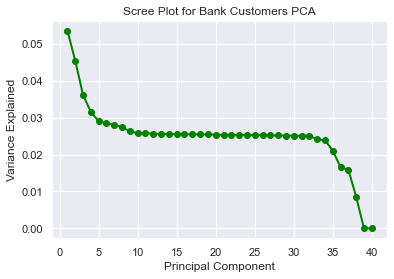

In [50]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='green')
plt.title('Scree Plot for Bank Customers PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Facinating output... 
# this flat line because each of the encoded states does not contribute much to explained variance

In [51]:
# Lets try again without the encoded states

#make new df with only needed columns
df_customer_norm2 = pd.DataFrame(df_customer_norm).iloc[:, :7]

pca = PCA()
pca.fit(df_customer_norm2)
reduced_customer = pca.transform(df_customer_norm2)
print(reduced_customer.shape)

(747, 7)


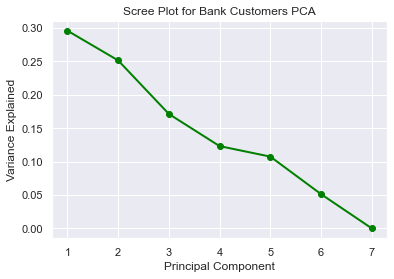

In [52]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='green')
plt.title('Scree Plot for Bank Customers PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Text(0, 0.5, '% Cumulative explained variance')

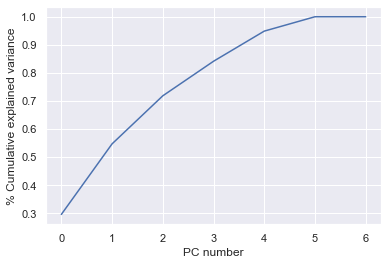

In [53]:
#cumulative plot 
cum_explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')
#at 3 dimensions we have 85% of var explained

In [54]:
# lets do again for 2 dimensions and pplot and see
pca = PCA(n_components=2)
pca.fit(df_customer_norm2)

reduced_customer = pca.transform(df_customer_norm2)
print(reduced_customer.shape)

x = reduced_customer[:, 0]
y = reduced_customer[:, 1]

fig = px.scatter(reduced_customer, x=x, y=y)
fig.update_layout( xaxis_title="q_1", yaxis_title="q_2")
fig.show()
# intreiging, lets back up and export the 5 PCs for clustering

(747, 2)


In [55]:
#lets output the dataframe to include the PCs up to 5 
pca = PCA(n_components=5)
pca.fit(df_customer_norm2)

reduced_customer = pca.transform(df_customer_norm2)
scores_pca = reduced_customer 

### 4. Clustering

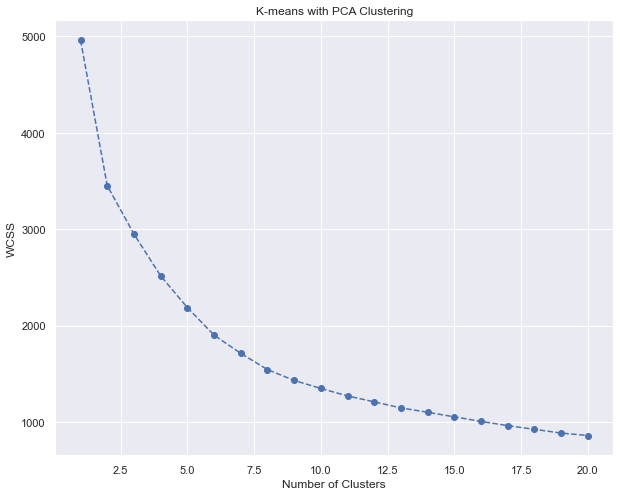

In [56]:
# detemin how many clusters we want
# we fit kmeans uising the transformed data from PCA

wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

# create plot for WCSS elbow plot
plt.figure(figsize=(10,8))
plt.plot(range(1,21), wcss, marker='o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

#elbow at 6 but lets do one less at 5 dimensions

In [58]:
#impliment clustering k-means using random state
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)

#fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

# put results in a new dataframe 
df_segm_pca_kmeans = pd.concat([df_customer_clean.iloc[:, :7].reset_index(drop = True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-5: ] = ['Component_1', 'Component_2', 'Component_3', 'Component_4', 'Component_5']

#the last column we add contains the pca k-means clusterin labels
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
# add names to segmentation labels
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'first',
                                                                               1:'second',
                                                                               2:'third',
                                                                               3:'fourth',
                                                                               4:'fith'})
df_segm_pca_kmeans.head()

,income,age,years_with_bank,nbr_children,marital_status,gender_F,gender_M,Component_1,Component_2,Component_3,Component_4,Component_5,Segment K-means PCA,Segment
0,26150,46,5,1,2,0.0,1.0,1.606596,-0.244269,0.214128,0.314374,-0.227185,3,fourth
1,6605,71,1,0,2,0.0,1.0,1.327042,-0.650699,0.428625,-1.796684,-1.008241,3,fourth
2,18548,38,8,0,1,1.0,0.0,-1.468098,-0.459330,1.263136,1.097198,0.490317,2,third
3,47668,54,3,0,1,1.0,0.0,-1.032716,0.213450,0.617491,-0.788948,1.583923,0,first
4,44554,59,9,2,4,1.0,0.0,-0.071040,3.258154,0.995800,1.219061,-0.467066,4,fith


In [66]:
# lets plot clusters
x_axis = df_segm_pca_kmeans["Component_2"]
y_axis = df_segm_pca_kmeans["Component_1"]
cluster = df_segm_pca_kmeans['Segment']

fig = px.scatter(df_segm_pca_kmeans, x=x_axis, y=y_axis, color=cluster)
fig.update_layout( xaxis_title="PCA_2", yaxis_title="PCA_1")
fig.show()
#this is plotly scatter for PC1 & PC2

In [67]:
x_axis = df_segm_pca_kmeans["Component_3"]
y_axis = df_segm_pca_kmeans["Component_1"]
cluster = df_segm_pca_kmeans['Segment']

fig = px.scatter(df_segm_pca_kmeans, x=x_axis, y=y_axis, color=cluster)
fig.update_layout( xaxis_title="PCA_3", yaxis_title="PCA_1")
fig.show()
#this is plotly scatter for PC1 & PC3

In [60]:
#biplot 
df_temp = df_segm_pca_kmeans.iloc[:, :7] #temp df
features = df_segm_pca_kmeans.iloc[:, :7].columns #shows only columns w features used
cluster = df_segm_pca_kmeans['Segment']

pca = PCA(n_components=2)
components = pca.fit_transform(df_temp)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=cluster)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i,0],
        y1=loadings[i,1]
    )
    fig.add_annotation(
        x=loadings[i,0],
        y=loadings[i,1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )

fig.show()

In [68]:
# 3D plot of clusters
x_axis = df_segm_pca_kmeans["Component_2"]
y_axis = df_segm_pca_kmeans["Component_1"]
z_axis = df_segm_pca_kmeans["Component_3"]
cluster = df_segm_pca_kmeans['Segment']

fig = px.scatter_3d(df_segm_pca_kmeans, x='Component_2', y='Component_1', z='Component_3', color='Segment',
                    size_max=1, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker=dict(size=5,
                              ),
                  selector=dict(mode='markers'))
fig.show()

## Goal 2: Banking Behaviour

### 1. Create joined table of needed data

In [70]:
#query to get all accouts that have savings and their info
select_some = """
SELECT cust_id, minimum_balance, account_active, acct_start_date, ending_balance FROM df_savings
WHERE account_active LIKE '%Y%'
ORDER BY ending_balance DESC;
"""

savings_data = execute_read_query(connection, select_some)

# for elm in savings_data:
#     print(elm)

#saving the filtered query to a df
savings_active = pd.DataFrame(savings_data)
savings_active = savings_active.rename(columns={0:'cust_id', 1:'minimum_balance', 2:'account_active', 3:'acct_start_date', 4:'ending_balance'})
savings_active.rename(columns={'account_active':'savings_acct', 'acct_start_date':'sv_open_date', 'ending_balance':'sv_balance'}, inplace=True)
savings_active.drop(columns=['minimum_balance'], inplace=True)
savings_active.head()

,cust_id,savings_acct,sv_open_date,sv_balance
0,1362766,Y,29.11.1990,22432.78
1,1362725,Y,30.1.1995,16095.50
2,1362622,Y,8.4.1989,13404.16
3,1362573,Y,17.6.1990,10399.11
4,1363018,Y,28.10.1994,9387.66


In [71]:
# lets now join this onto the origional table before processing stuff

#copying table to not destroy the clean version from prior sections
df_part2 = df_customer.copy()
#this new df has the origional data and also the savings columns 
df_part2 = pd.merge(df_part2, savings_active, how='left', on=['cust_id'] )

In [72]:
#bring in the sql query for credit

select_some = """
SELECT cust_id, credit_limit, credit_rating, account_active as cr_acct, acct_start_date, ending_balance FROM df_credit
WHERE account_active LIKE '%Y%';
"""

credit_temp = pd.DataFrame(execute_read_query(connection, select_some))
credit_temp.rename(columns={0:'cust_id', 1:'cr_limit', 2:'cr_rating', 3:'cr_acct', 4:'acct_start_date', 5:'cr_balance' }, inplace=True)

#merge this with df_part2
test =pd.merge(df_part2, credit_temp, how='left', on='cust_id')
print(test.shape)
df_part2 = test
df_part2.head()
# we have now merged the credit account info

(747, 23)


,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code,savings_acct,sv_open_date,sv_balance,cr_limit,cr_rating,cr_acct,acct_start_date,cr_balance
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA,NaN,NaN,NaN,3000.0,0.0,Y,8.8.1995,1548.23
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA,Y,9.5.1988,122.54,1000.0,0.0,Y,12.10.1988,286.69
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA,Y,20.2.1995,609.33,NaN,NaN,NaN,NaN,NaN
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY,Y,11.11.1986,254.02,6700.0,0.0,Y,11.11.1986,68.68


In [74]:
# what about transactions!? 
# will bring in two tables, join them
# then join them both onto the main table
select_some = """
SELECT acct_nbr, count(tran_amt) as total_count, avg(tran_amt) as total_avg, sum(tran_amt) as total_sum 
FROM df_trans_clean
GROUP BY acct_nbr;
"""
temp1 = pd.DataFrame(execute_read_query(connection, select_some))
temp1.rename(columns={0:'acct_nbr', 1:'total_count', 2:'total_avg', 3:'total_sum'}, inplace=True)

select_some = """
SELECT acct_nbr, AVG(m_t_count) AS avg_month_count, AVG(m_t_sum) AS avg_month_amt
FROM (
    SELECT acct_nbr, tran_month, count(tran_amt) as m_t_count, avg(tran_amt) as m_t_avg, sum(tran_amt) as m_t_sum 
    FROM df_trans_clean
    GROUP BY acct_nbr, tran_month
)
GROUP BY acct_nbr;
"""

temp2 = pd.DataFrame(execute_read_query(connection, select_some))
temp2.rename(columns={0:'acct_nbr', 1:'avg_month_count', 2:'avg_month_amt'}, inplace=True)

temp3 = pd.merge(temp1, temp2, how='left', on='acct_nbr')
temp3.rename(columns={'total_count':'t_tot_count', 'total_avg':'t_tot_avg', 'total_sum':'t_tot_sum', 'avg_month_count':'t_m_av_count', 'avg_month_amt':'t_m_av_amt'}, inplace=True)

# lets just write this to the db for now and join in there for paractice
temp3.to_sql('view_t_metrics', connection)

temp3.head()

,acct_nbr,t_tot_count,t_tot_avg,t_tot_sum,t_m_av_count,t_m_av_amt
0,13624802,99,-2.474646,-244.99,8.250000,-20.415833
1,13624803,26,18.550769,482.32,2.166667,40.193333
2,13624842,99,-25.435758,-2518.14,9.000000,-228.921818
3,13624843,33,58.474545,1929.66,2.750000,160.805000
4,13624852,99,-1.659495,-164.29,9.900000,-16.429000


In [75]:
# lets bring in the table w cust numbers and then join to main
select_some = """
SELECT cust_id, count(acct_nbr), avg(t_tot_count), avg(t_tot_avg), avg(t_tot_sum), avg(t_m_av_count), avg(t_m_av_amt)  FROM df_accts
    JOIN view_t_metrics USING ('acct_nbr')
GROUP BY cust_id
;
"""

temp1 = pd.DataFrame(execute_read_query(connection, select_some))
temp1.rename(columns={0:'cust_id', 1:'num_of_accts', 2:'t_tot_count', 3:'t_tot_avg', 4:'t_tot_sum', 5:'t_m_av_count', 6:'t_m_av_amt'}, inplace=True)
temp2 = pd.merge(df_part2, temp1, how='left', on='cust_id')

df_part2 = temp2

print(df_part2.shape)
df_part2.head()

(747, 29)


,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code,savings_acct,sv_open_date,sv_balance,cr_limit,cr_rating,cr_acct,acct_start_date,cr_balance,num_of_accts,t_tot_count,t_tot_avg,t_tot_sum,t_m_av_count,t_m_av_amt
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA,NaN,NaN,NaN,3000.0,0.0,Y,8.8.1995,1548.23,3.0,34.333333,-36.041205,-1184.373333,3.117845,-108.490715
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA,Y,9.5.1988,122.54,1000.0,0.0,Y,12.10.1988,286.69,2.0,58.000000,2.893297,194.765000,4.833333,16.230417
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA,Y,20.2.1995,609.33,NaN,NaN,NaN,NaN,NaN,3.0,40.000000,51.998539,643.930000,3.916667,147.252778
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY,Y,11.11.1986,254.02,6700.0,0.0,Y,11.11.1986,68.68,3.0,44.333333,87.522290,515.446667,4.555556,223.042424


### 2. Data Cleaning 

In [76]:
#using sql I confirmed that the 83 rows do not have any active acounts. Thus, removed rows for now.
not_active = df_part2.loc[df_part2['num_of_accts'].isnull()].index
test = df_part2.copy()
test = test.drop(not_active)
df_clean = test

# drop unneeded columns
df_clean.drop(columns=['name_prefix', 'first_name', 'last_name', 'street_nbr', 'street_name', 'postal_code', 'city_name', 'sv_open_date', 'acct_start_date'], inplace=True)

# need to make each column absolute that is not 
df_clean['t_tot_avg'] = df_clean['t_tot_avg'].abs()
df_clean['t_tot_sum'] = df_clean['t_tot_sum'].abs()
df_clean['t_m_av_count'] = df_clean['t_m_av_count'].abs()
df_clean['t_m_av_amt'] = df_clean['t_m_av_amt'].abs()

# fill nans with 0 
df_clean['savings_acct'] = df_clean['savings_acct'].str.strip().replace({'Y':1}).fillna(0)
df_clean['cr_acct'] = df_clean['cr_acct'].str.strip().replace({'Y':1}).fillna(0)

# what to do with remaining NaN values in the following columns??? : 'cr_limit', 'cr_rating', 'cr_balance'
# for cr_limit: NaN = 

#lets fix the credit columns 
credit_temp.head() #need to rejoin this onto cleaned datas and continue processing
temp1 = df_clean.drop(columns=['cr_limit', 'cr_rating', 'cr_acct', 'cr_balance'])

temp_c = pd.merge(temp1, credit_temp, how='left', on='cust_id')
df_clean = temp_c
#this fixed issues of not having all credit records 

df_clean.head(10)


,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,state_code,savings_acct,sv_balance,num_of_accts,t_tot_count,t_tot_avg,t_tot_sum,t_m_av_count,t_m_av_amt,cr_limit,cr_rating,cr_acct,acct_start_date,cr_balance
0,1362487,6605,71,1,0,M,2,CA,0.0,NaN,3.0,34.333333,36.041205,1184.373333,3.117845,108.490715,3000.0,0.0,Y,8.8.1995,1548.23
1,1363160,18548,38,8,0,F,1,CA,1.0,122.54,2.0,58.000000,2.893297,194.765000,4.833333,16.230417,1000.0,0.0,Y,12.10.1988,286.69
2,1362752,47668,54,3,0,F,1,CA,1.0,609.33,3.0,40.000000,51.998539,643.930000,3.916667,147.252778,NaN,NaN,NaN,NaN,NaN
3,1362548,44554,59,9,2,F,4,NY,1.0,254.02,3.0,44.333333,87.522290,515.446667,4.555556,223.042424,6700.0,0.0,Y,11.11.1986,68.68
4,1363017,0,16,1,0,M,1,CA,0.0,NaN,3.0,62.000000,1.271352,871.176667,5.636364,79.197879,1000.0,0.0,Y,8.2.1995,1000.00
5,1362609,1929,79,8,0,F,2,HI,1.0,49.39,3.0,58.000000,22.818788,1376.740000,4.833333,114.728333,3000.0,0.0,Y,20.7.1992,3000.00
6,1363486,39942,41,1,5,F,4,HI,0.0,NaN,1.0,38.000000,0.000000,0.000000,9.500000,0.000000,2000.0,10.0,Y,8.12.1995,0.00
7,1363078,9622,46,6,1,M,2,HI,1.0,596.38,3.0,58.333333,14.328563,549.973333,5.388889,52.794303,3000.0,0.0,Y,6.4.1991,1147.07
8,1363282,25829,29,8,0,F,1,DC,0.0,NaN,2.0,63.500000,2.912909,119.890000,5.428030,10.710758,1300.0,0.0,Y,12.1.1988,272.69
9,1363343,0,15,0,0,M,1,TX,1.0,2007.65,1.0,41.000000,34.241951,1403.920000,3.416667,116.993333,NaN,NaN,NaN,NaN,NaN


In [77]:
#ok now, sv_balance make 0 if missing
# cr_limit and cr_rating to 0

df_clean['cr_limit'] = df_clean['cr_limit'].fillna(0)
df_clean['cr_rating'] = df_clean['cr_rating'].fillna(0)
df_clean['cr_acct'] = df_clean['cr_acct'].fillna(0)
df_clean['cr_acct'] = df_clean['cr_acct'].replace('Y ', 1)
df_clean['sv_balance'] = df_clean['sv_balance'].fillna(0)
df_clean['cr_balance'] = df_clean['cr_balance'].fillna(0)
df_clean.drop(columns='acct_start_date', inplace=True)

# check for remaining null values
df_clean.isnull().sum()

cust_id            0
income             0
age                0
years_with_bank    0
nbr_children       0
gender             0
marital_status     0
state_code         0
savings_acct       0
sv_balance         0
num_of_accts       0
t_tot_count        0
t_tot_avg          0
t_tot_sum          0
t_m_av_count       0
t_m_av_amt         0
cr_limit           0
cr_rating          0
cr_acct            0
cr_balance         0
dtype: int64

In [ ]:
# creat dummies
new_state_cols = pd.get_dummies(df_clean['gender'])
test = pd.concat([df_clean, new_state_cols], axis=1)
test.drop(columns='gender', inplace=True)
df_clean = test

In [80]:
df_clean.head()

,cust_id,income,age,years_with_bank,nbr_children,marital_status,state_code,savings_acct,sv_balance,num_of_accts,t_tot_count,t_tot_avg,t_tot_sum,t_m_av_count,t_m_av_amt,cr_limit,cr_rating,cr_acct,cr_balance,F,M
0,1362487,6605,71,1,0,2,CA,0.0,0.00,3.0,34.333333,36.041205,1184.373333,3.117845,108.490715,3000.0,0.0,1,1548.23,0,1
1,1363160,18548,38,8,0,1,CA,1.0,122.54,2.0,58.000000,2.893297,194.765000,4.833333,16.230417,1000.0,0.0,1,286.69,1,0
2,1362752,47668,54,3,0,1,CA,1.0,609.33,3.0,40.000000,51.998539,643.930000,3.916667,147.252778,0.0,0.0,0,0.00,1,0
3,1362548,44554,59,9,2,4,NY,1.0,254.02,3.0,44.333333,87.522290,515.446667,4.555556,223.042424,6700.0,0.0,1,68.68,1,0
4,1363017,0,16,1,0,1,CA,0.0,0.00,3.0,62.000000,1.271352,871.176667,5.636364,79.197879,1000.0,0.0,1,1000.00,0,1


In [81]:
# save file 
df_clean.to_csv(d_path + 'temp/g2_clean_output_1.csv')

### 3. Ralation Matrix

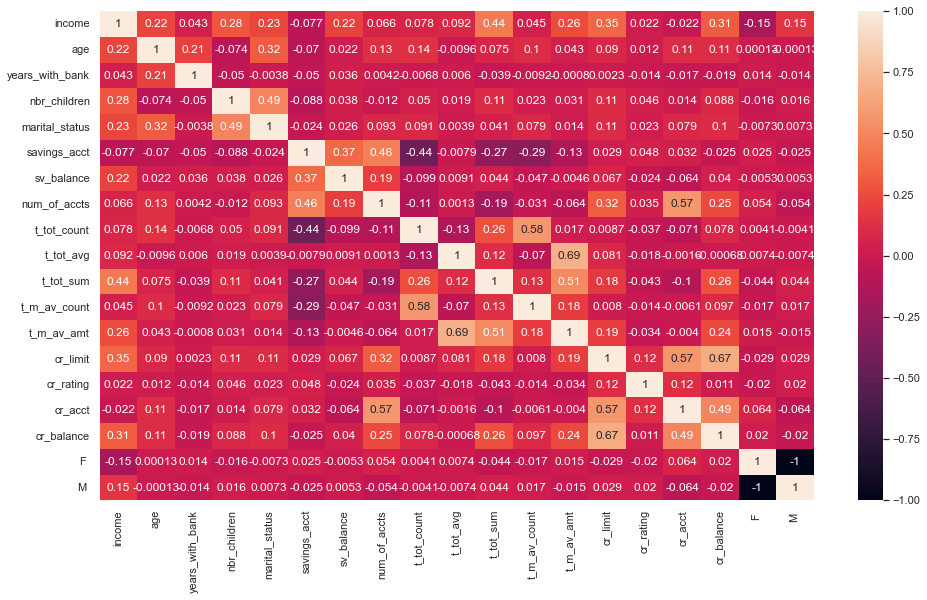

In [82]:
df_clean.drop(columns=['cust_id', 'state_code'], axis=1, inplace=True)

corMat = df_clean.corr()
fig = plt.subplots(figsize=(16,9))
sns.heatmap(corMat, annot=True)
plt.show()

### 4. Normalize 

In [83]:
df2_norm = StandardScaler().fit_transform(df_clean)
pd.DataFrame(df2_norm, columns=df_clean.columns).head()

,income,age,years_with_bank,nbr_children,marital_status,savings_acct,sv_balance,num_of_accts,t_tot_count,t_tot_avg,t_tot_sum,t_m_av_count,t_m_av_amt,cr_limit,cr_rating,cr_acct,cr_balance,F,M
0,-0.742159,1.506332,-1.062206,-0.641088,0.105412,-1.139113,-0.424288,1.143387,-0.931004,0.013378,0.138955,-0.628541,-0.035652,0.648872,-0.161542,0.754811,0.577391,-1.178342,1.178342
1,-0.204155,-0.247760,1.540394,-0.641088,-0.971411,0.877876,-0.353634,-0.132595,0.063225,-0.184490,-0.654160,-0.159336,-0.413148,-0.286947,-0.161542,0.754811,-0.417097,0.848650,-0.848650
2,1.107633,0.602709,-0.318606,-0.641088,-0.971411,0.877876,-0.072963,1.143387,-0.692949,0.108631,-0.294180,-0.410054,0.122949,-0.754856,-0.161542,-1.324835,-0.643098,0.848650,-0.848650
3,0.967354,0.868480,1.912194,1.166481,2.259058,0.877876,-0.277826,1.143387,-0.510907,0.320681,-0.397152,-0.235311,0.433053,2.380138,-0.161542,0.754811,-0.588957,0.848650,-0.848650
4,-1.039699,-1.417154,-1.062206,-0.641088,-0.971411,-1.139113,-0.424288,1.143387,0.231264,-0.194172,-0.112054,0.060302,-0.155508,-0.286947,-0.161542,0.754811,0.145214,-1.178342,1.178342


### 5. PCA

(664, 19)


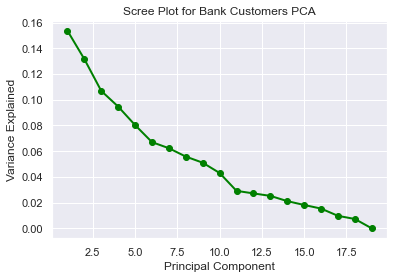

Text(0, 0.5, '% Cumulative explained variance')

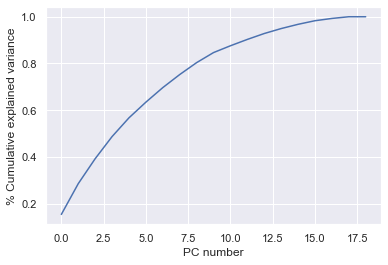

In [84]:
#making pca with all dimensions for an elbow plot
pca = PCA()
pca.fit(df2_norm)

reduced_customer = pca.transform(df2_norm)
print(reduced_customer.shape)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='green')
plt.title('Scree Plot for Bank Customers PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

cum_explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')

In [85]:
# lets do PCA for 10 dimensions and save
pca = PCA(n_components=10)
pca.fit(df2_norm)

reduced_customer = pca.transform(df2_norm)
print(reduced_customer.shape)

#lets output all the PCs and save them for clustering test
scores_pca = reduced_customer  

(664, 10)


### 6. Clustering

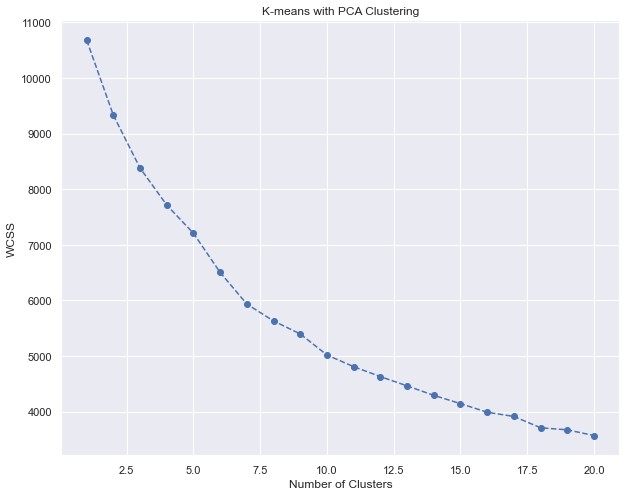

In [86]:
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state = None)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

# create plot for WCSS elbow plot
plt.figure(figsize=(10,8))
plt.plot(range(1,21), wcss, marker='o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

#elbow at 7

In [87]:
#impliment clustering k-means using random state as before

kmeans_pca = KMeans(n_clusters=7, init='k-means++', random_state= None)

#fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=7)

In [92]:
# Join PCA and Clustering results onto origional DF
df_segm_pca_kmeans = pd.concat([df_clean, pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-10: ] = ['Component_1', 'Component_2', 'Component_3', 'Component_4', 'Component_5', 'Component_6','Component_7','Component_8', 'Component_9', 'Component_10']
#the last column we add contains the pca k-means clusterin labels
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
# add names to segmentation labels
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'first',
                                                                               1:'second',
                                                                               2:'third',
                                                                               3:'fourth',
                                                                               4:'fith',
                                                                               5:'sixth',
                                                                               6:'seventh'})
df_segm_pca_kmeans.head()

,income,age,years_with_bank,nbr_children,marital_status,savings_acct,sv_balance,num_of_accts,t_tot_count,t_tot_avg,t_tot_sum,t_m_av_count,t_m_av_amt,cr_limit,cr_rating,cr_acct,cr_balance,F,M,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,Segment K-means PCA,Segment
0,6605,71,1,0,2,0.0,0.00,3.0,34.333333,36.041205,1184.373333,3.117845,108.490715,3000.0,0.0,1,1548.23,0,1,0.836631,-0.623350,-1.376442,-0.522025,-1.273456,-0.043184,1.049303,0.078187,-0.757025,-1.731487,5,sixth
1,18548,38,8,0,1,1.0,122.54,2.0,58.000000,2.893297,194.765000,4.833333,16.230417,1000.0,0.0,1,286.69,1,0,-1.119499,-1.022732,1.044427,-0.024929,-0.519891,0.986462,0.355440,-0.617283,0.035197,0.982874,0,first
2,47668,54,3,0,1,1.0,609.33,3.0,40.000000,51.998539,643.930000,3.916667,147.252778,0.0,0.0,0,0.00,1,0,-0.953861,-0.722567,0.551424,1.167542,0.664937,1.061056,-0.456392,-0.038196,0.210524,-1.004106,6,seventh
3,44554,59,9,2,4,1.0,254.02,3.0,44.333333,87.522290,515.446667,4.555556,223.042424,6700.0,0.0,1,68.68,1,0,2.164896,-1.874310,0.707388,-0.197583,2.027257,0.388385,1.885632,-0.158930,-0.402857,1.002408,0,first
4,0,16,1,0,1,0.0,0.00,3.0,62.000000,1.271352,871.176667,5.636364,79.197879,1000.0,0.0,1,1000.00,0,1,-0.513756,0.060137,-1.141713,-0.540945,-2.345804,-0.927185,-0.538523,0.829732,-0.467632,0.152890,5,sixth


In [93]:
x_axis = df_segm_pca_kmeans["Component_2"]
y_axis = df_segm_pca_kmeans["Component_1"]
z_axis = df_segm_pca_kmeans["Component_3"]
cluster = df_segm_pca_kmeans['Segment']

fig = px.scatter_3d(df_segm_pca_kmeans, x='Component_2', y='Component_1', z='Component_3', color='Segment',
                    size_max=1, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker=dict(size=5,
                              ),
                  selector=dict(mode='markers'))
fig.show()

In [94]:
df_for_summary = df_segm_pca_kmeans[['Segment K-means PCA', 'Segment', 'income', 'age', 'years_with_bank', 'nbr_children', 'num_of_accts', 'sv_balance', 'cr_balance']]
df_for_summary.sort_values(by='Segment K-means PCA').groupby(by='Segment K-means PCA').agg('mean').round()

,income,age,years_with_bank,nbr_children,num_of_accts,sv_balance,cr_balance
Segment K-means PCA,,,,,,,
0,17432.0,46.0,4.0,1.0,3.0,569.0,1038.0
1,58636.0,45.0,3.0,2.0,2.0,1974.0,3441.0
2,30006.0,47.0,4.0,1.0,1.0,51.0,25.0
3,26319.0,42.0,4.0,1.0,2.0,489.0,867.0
4,32802.0,40.0,4.0,1.0,2.0,378.0,0.0
5,19155.0,40.0,4.0,1.0,2.0,732.0,558.0
6,15762.0,34.0,4.0,1.0,2.0,1075.0,25.0


In [1]:
# Next Step is to refactor the many additional data manipulation and feature engineering attempts cleanly into this notebook